# Goal: Utilize a neural network/random forest/xgBoost on demographic data only → predict DR → determine the top predictive features by SHAP value

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# import the data
from google.colab import drive
drive.mount('/content/drive')
demos_original = pd.read_csv('/content/drive/MyDrive/6.S058 DR Diagnosis/labels_mbrset.csv')

random.seed(69)

Mounted at /content/drive


In [2]:
nans = demos_original.query('final_icdr != final_icdr').index  # 280 NaN icdrs
final_quality_no = demos_original.query('final_quality == "no"').index  # 292 no
demos = demos_original.drop(index = nans, inplace=False)

# subset to unique patients
demos = demos.drop_duplicates(subset=['patient'])
print(demos.patient.nunique())

1287


## explore the NaNs
Conclusion: there is very high correlation between final_quality == 'no' and final_icdr == NaN, although imperfect; it makes most sense for us to drop the NaNs as these are the values we are predicting

In [ ]:
demos_original.final_icdr.value_counts(dropna=False)

,count
final_icdr,
0.0,3750
2.0,568
NaN,280
1.0,272
4.0,212
3.0,82


In [ ]:
# Step 1: Identify patients with both NaN and non-NaN final_icdr values
# Find patients with NaN values in final_icdr
patients_with_nan = set(demos_original[demos_original['final_icdr'].isna()]['patient'])

# Find patients with non-NaN values in final_icdr
patients_with_values = set(demos_original[demos_original['final_icdr'].notna()]['patient'])

# Find patients that appear in both sets (have both NaN and non-NaN entries)
patients_with_both = patients_with_nan.intersection(patients_with_values)

# Step 2: Get all rows for these patients to see their complete data
result = demos_original[demos_original['patient'].isin(patients_with_both)].loc[:, ('patient', 'final_icdr')]

# Optional: If you only want to see the rows with NaN values for these patients
nan_result = result[result['final_icdr'].isna()]

# Optional: If you want to focus only on patient ID and final_icdr columns
nan_result_focused = nan_result[['patient', 'final_icdr']]

# Display the result (choose one of the above options depending on your needs)
# For all data for patients with both NaN and non-NaN values:
result

# For only the NaN rows for these patients:
# nan_result

# For just the patient ID and final_icdr from NaN rows:
# nan_result_focused

,patient,final_icdr
20,1002,NaN
21,1002,NaN
22,1002,0.0
23,1002,0.0
36,1006,0.0
...,...,...
5115,987,4.0
5156,998,2.0
5157,998,2.0
5158,998,NaN


## train a neural network to predict final_icdr from demographic features

In [3]:
# BY THE END OF THIS you get features is 1287 by 17

# ~4000 NaNs here so seems silly to include
demos.drop('insulin_time', axis=1, inplace=True)   # comment out if already ran once

features = list(demos.columns[1:-2]) # ignore patient column
features.append('final_edema')

# remove features not associated with demographics
features.remove('file')
features.remove('final_artifacts')
features.remove('final_quality')
features.remove('laterality')
print(demos.patient.nunique())

demos = demos.apply(lambda x: x.fillna(x.mode()[0]) if x.isna().any() else x)  # impute with mode
demos.drop(demos[demos.isna().any(axis=1)].index, inplace=True)
print(demos.patient.nunique())
# print(demos.isna().any())
features = demos[features]

# convert no/yes to binary numbers
features.final_edema.where(features.final_edema == 'no', 1.0, inplace=True)
features.final_edema.where(features.final_edema != 'no', 0.0, inplace=True)

# convert >= 90 ages to
features.age.where(features.age != '>= 90', '90', inplace=True)

features_tensor = torch.tensor(features.to_numpy().astype('float32'))


# get labels
labels_tensor = torch.tensor(demos.final_icdr.to_numpy().astype('long'))

1287
1287


<ipython-input-3-ac9a09cd6081>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features.final_edema.where(features.final_edema == 'no', 1.0, inplace=True)
<ipython-input-3-ac9a09cd6081>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.final_edema.where(features.final_edema == 'no', 1.0, inplace=True)
<ipython-input-3-ac9a09cd6081>:

In [ ]:
demos.final_icdr.value_counts()

,count
final_icdr,
0.0,992
2.0,144
1.0,80
4.0,52
3.0,19


In [4]:
# train/test split
features_train, features_test, labels_train, labels_test = train_test_split(features_tensor, labels_tensor, test_size=0.2, random_state=69)
data_train = torch.utils.data.TensorDataset(features_train, labels_train)
loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)

if torch.isnan(features_train).any():
    print("Input contains NaNs")
if torch.isinf(features_train).any():
    print("Input contains infinities")

from sklearn.preprocessing import StandardScaler

# scale the tabular features from the training dataset
scaler = StandardScaler()
features_train = torch.tensor(scaler.fit_transform(features_train), dtype=torch.float32)

# then apply same scaling to test dataset
features_test = torch.tensor(scaler.transform(features_test), dtype=torch.float32)

In [5]:
class Demo(torch.nn.Module):
    def __init__(self):
        super(Demo, self).__init__()
        self.fc1 = torch.nn.Linear(17, 32)
        self.fc2 = torch.nn.Linear(32, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)  # No softmax here
        return x

model = Demo()
model.to(device)

samples_per_class = list(demos.final_icdr.value_counts().sort_index())
total_samples = sum(samples_per_class)
weights_per_class = torch.tensor([1/samples_per_class[0],
                                  1/samples_per_class[1],
                                  1/samples_per_class[2],
                                  1/samples_per_class[3],
                                  1/samples_per_class[4]])
weights_per_class = weights_per_class/weights_per_class.sum() * total_samples

criterion = torch.nn.CrossEntropyLoss(weight = weights_per_class)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [ ]:
for _ in range(epochs):
  model.train()  # Set the model to training mode
  running_loss = 0.0

  for features, labels in loader:
    # import pdb;pdb.set_trace()
    # move to device
    features = features.to(device)
    labels = labels.to(device)

    # zero the gradients
    optimizer.zero_grad()

    # forward pass
    output = model(features)
    loss = criterion(output, labels)

    # backward pass
    loss.backward()
    optimizer.step()  # update model params

    running_loss += loss.item()

  print(f'Epoch {_+1}, Loss: {running_loss / len(loader)}')


Epoch 1, Loss: 2.900574611895012
Epoch 2, Loss: 1.6531093445691196
Epoch 3, Loss: 1.5734414945949207
Epoch 4, Loss: 1.5455195434165723
Epoch 5, Loss: 1.5424755016962688
Epoch 6, Loss: 1.5267949501673381
Epoch 7, Loss: 1.5046958887215816
Epoch 8, Loss: 1.4997780359152593
Epoch 9, Loss: 1.4820137312917998
Epoch 10, Loss: 1.4871743375604802


In [7]:
model.eval()
with torch.no_grad():
  output = model(features_test)
  _, predicted = torch.max(output, 1)
  correct = (predicted == labels_test).sum().item()
  total = labels_test.size(0)
  print(f'Accuracy: {np.round(100 * correct / total, 2)}%')

# torch.save(model.state_dict(), '/content/drive/MyDrive/6.S058 DR Diagnosis/demo_model.state_dict')

Accuracy: 68.6%


In [6]:
state_dict = torch.load('/content/drive/MyDrive/6.S058 DR Diagnosis/demo_model.state_dict')

# Load the state_dict into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

# JEANNIE CM

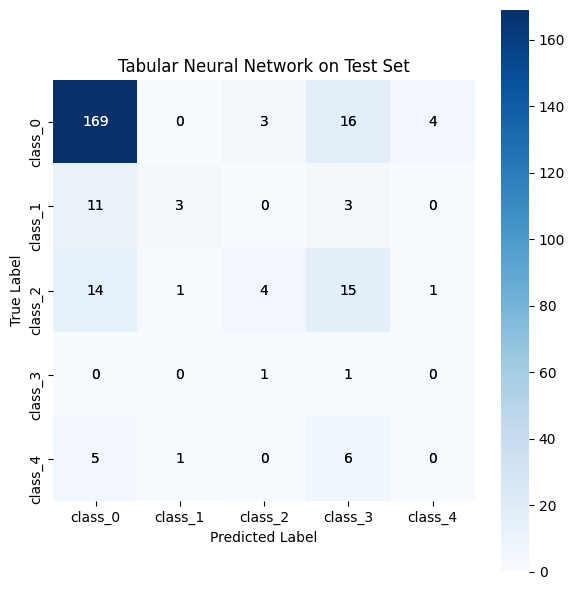

In [12]:
def plot_cf(preds, true, title, class_names=None):
    """
    Creates a confusion matrix with fixed class tick marks and custom styling.

    Parameters:
    preds: array-like, list of predictions
    true: array-like, list of true labels
    title: str, title for the figure
    class_names: list of all class labels (e.g., ['class_0', ..., 'class_4'])

    Returns:
    fig: matplotlib.figure.Figure object
    """
    # Define fixed label set (default to 0–4)
    if class_names is None:
        class_names = [f'class_{i}' for i in range(5)]  # modify if you have different classes

    labels = list(range(len(class_names)))  # [0, 1, 2, 3, 4]

    # Compute full confusion matrix with fixed labels
    cm = confusion_matrix(true, preds, labels=labels)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", ax=ax, colorbar=True)

    # Customize tick labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_yticklabels(class_names, rotation=90)

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

    # Style adjustments
    for spine in ax.spines.values():
        spine.set_visible(False)

    cbar = disp.im_.colorbar
    if cbar:
        cbar.outline.set_visible(False)


    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)
    plt.tight_layout()
    # plt.show()

    return fig

foo = plot_cf(predicted.cpu(), labels_test.cpu(), 'Tabular Neural Network on Test Set')

# foo.savefig('tabular_cf.png', dpi=300, bbox_inches='tight')

# CONFUSION MATRIX CODE (old)

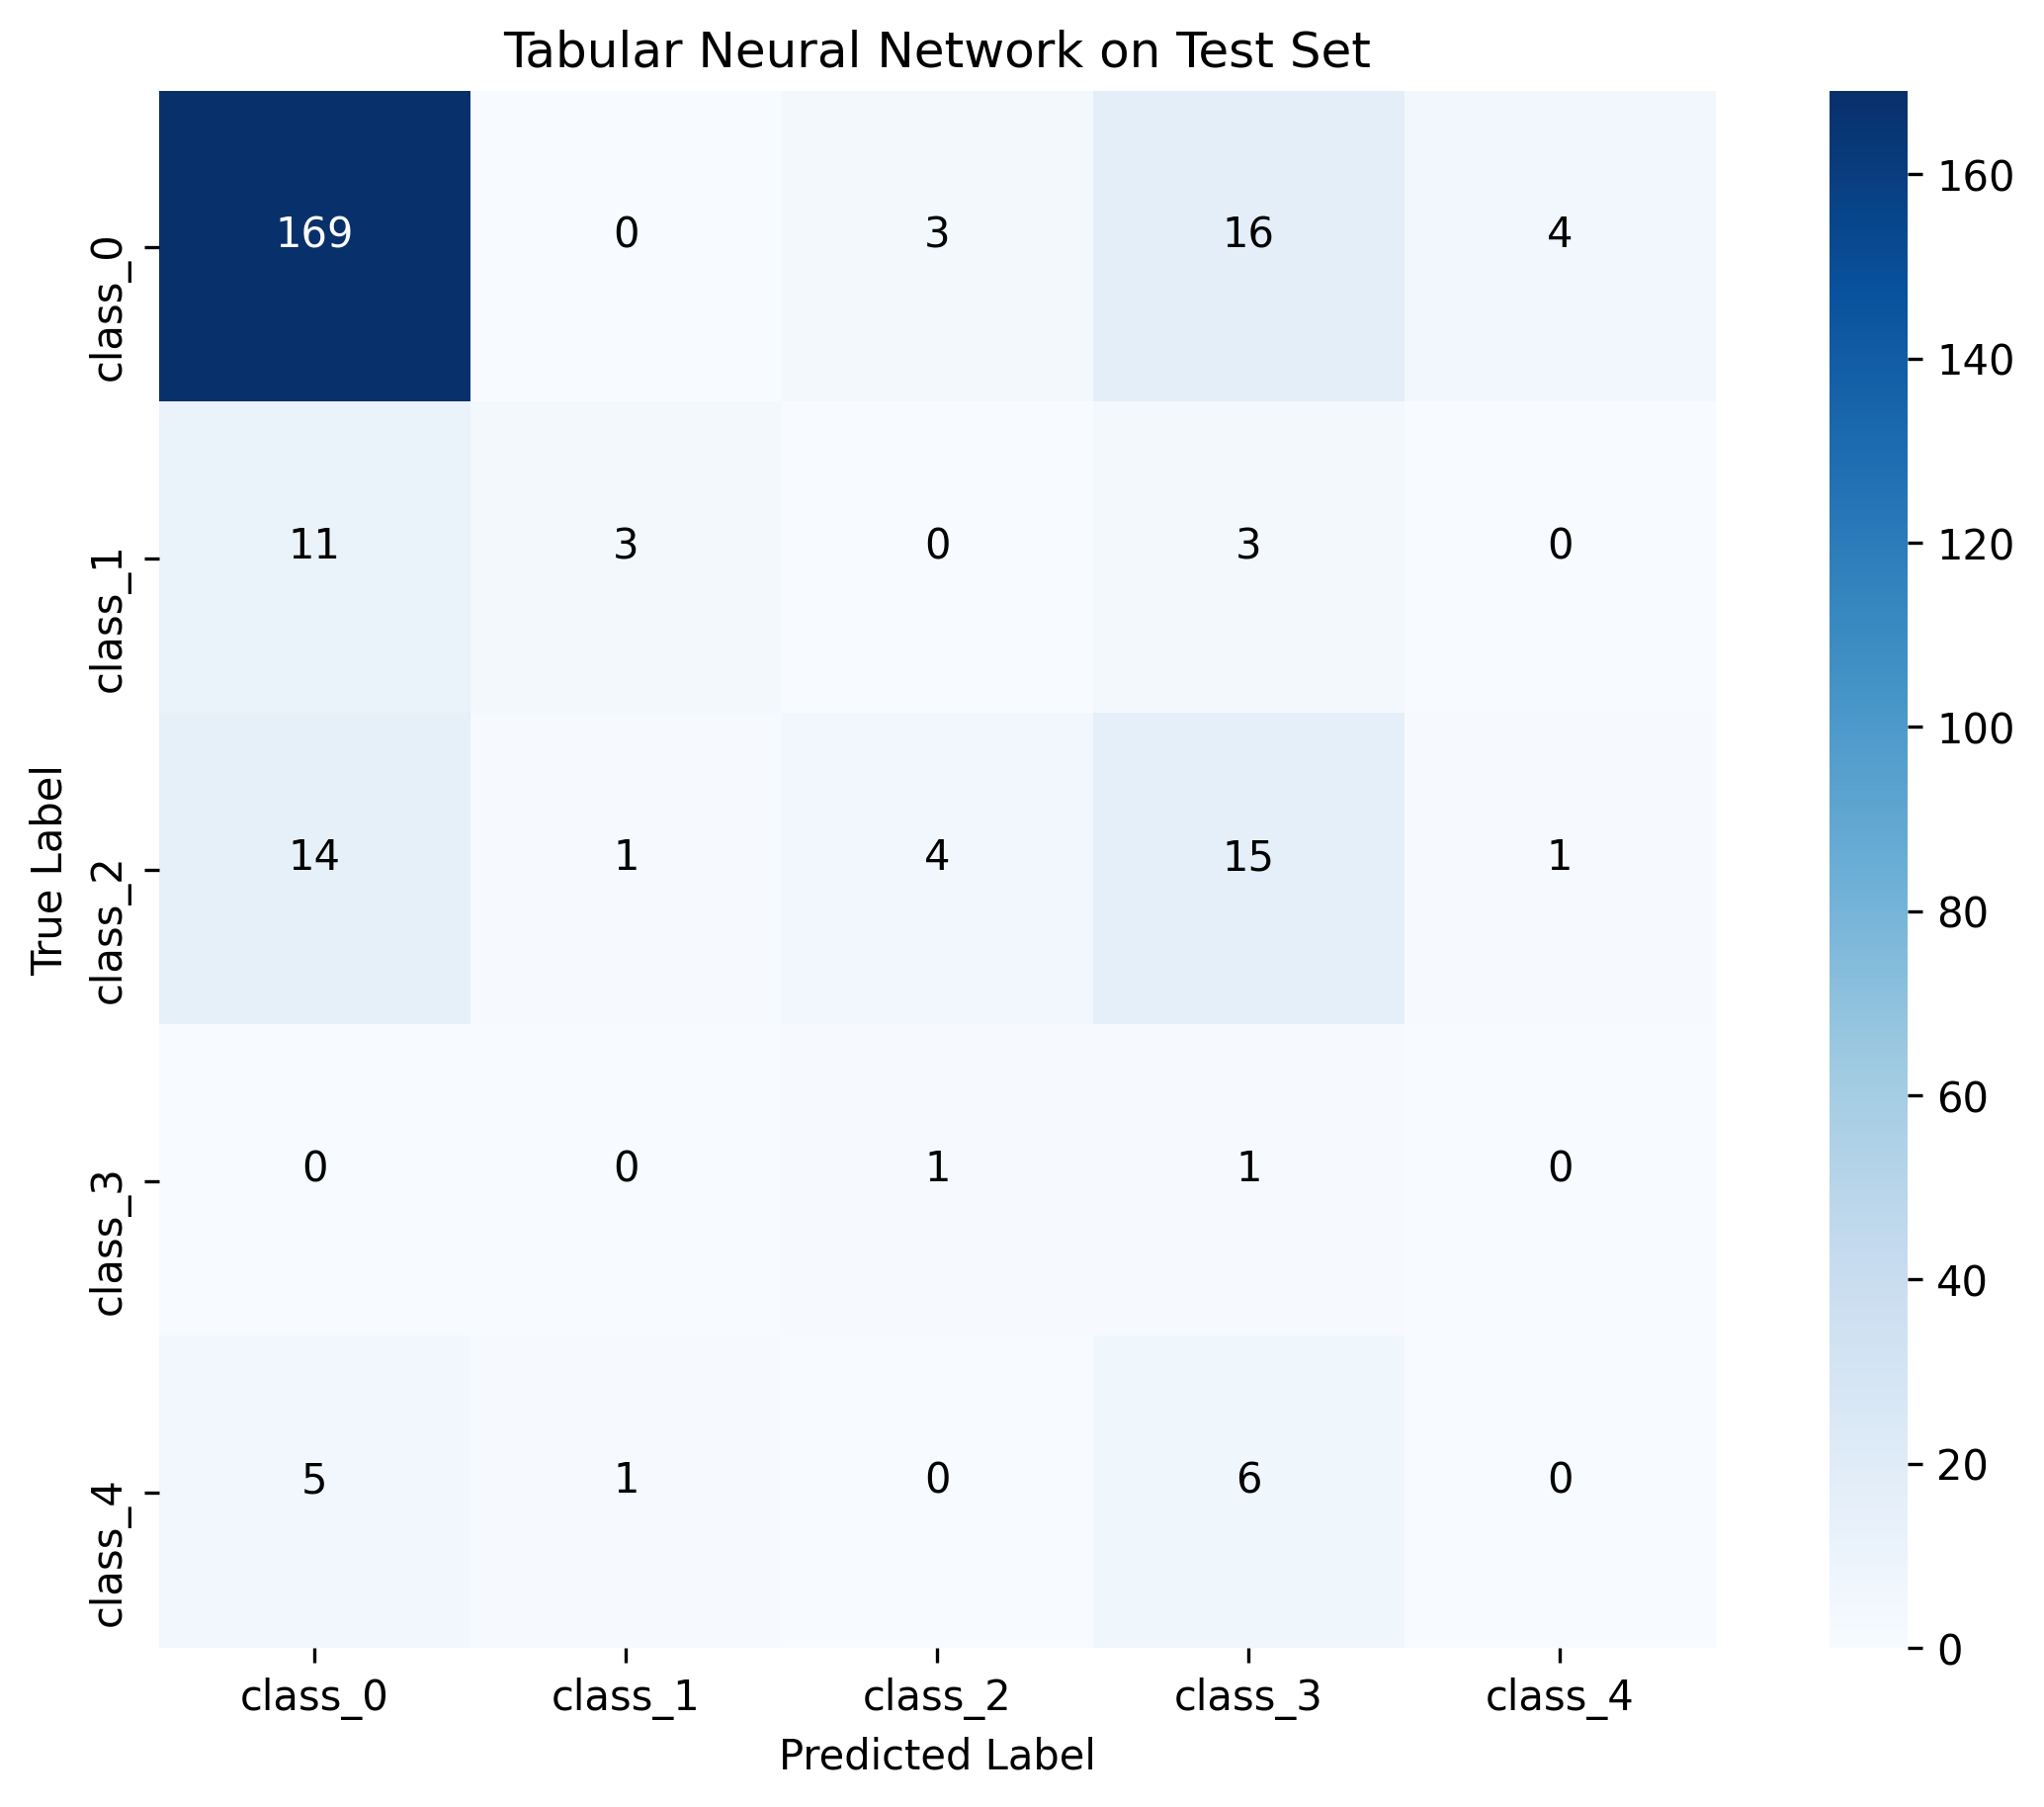

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(labels_test.cpu(), predicted.cpu())

# Create figure with transparent background
fig = plt.figure(figsize=(8, 6), frameon=False, dpi=300)

# Plot the confusion matrix without border
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Tabular Neural Network on Test Set')
cbar = plt.colorbar()
cbar.outline.set_visible(False)

classes = np.unique(labels_test.cpu())  # Assuming labels are integers representing classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, list('class_' + str(i) for i in classes))
plt.yticks(tick_marks, list('class_' + str(i) for i in classes), rotation=90)

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Remove the axes spines/borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## AUROC

In [24]:
from sklearn.metrics import roc_auc_score
import torch
from torch import nn

# generate logits, labels from data

# on test
with torch.no_grad():
  output = model(features_test)
  _, predicted = torch.max(output, 1)
  correct = (predicted == labels_test).sum().item()
  total = labels_test.size(0)
  print(f'Accuracy: {np.round(100 * correct / total, 2)}%')

probs = nn.functional.softmax(output, dim=1).cpu().numpy()
test_auroc = roc_auc_score(labels_test, probs, multi_class='ovr')

# on train
with torch.no_grad():
  output = model(features_train)
  _, predicted = torch.max(output, 1)
  correct = (predicted == labels_train).sum().item()
  total = labels_train.size(0)
  print(f'Accuracy: {np.round(100 * correct / total, 2)}%')

probs = nn.functional.softmax(output, dim=1).cpu().numpy()
train_auroc = roc_auc_score(labels_train, probs, multi_class='ovr')

Accuracy: 68.6%
Accuracy: 73.86%


In [25]:
test_auroc, train_auroc

(np.float64(0.6568728940939781), np.float64(0.6376223700819542))

## shap scores

In [ ]:
import shap
def model_wrapper(array):
  ''' wrapper around the torch model() function to pass into shap explainer '''
  array = torch.tensor(array).to(device)
  return torch.nn.functional.softmax(model(array)).cpu().detach().numpy()

feature_names = ['age', 'sex', 'dm_time', 'insulin', 'oraltreatment_dm',
      'systemic_hypertension', 'insurance', 'educational_level',
      'alcohol_consumption', 'smoking', 'obesity', 'vascular_disease',
      'acute_myocardial_infarction', 'nephropathy', 'neuropathy',
      'diabetic_foot', 'final_edema']

In [ ]:
features_test_df = pd.DataFrame(features_test, columns=feature_names)
explainer = shap.KernelExplainer(model_wrapper, shap.sample(features_test_df, 50), feature_names=feature_names)
shap_values = explainer.shap_values(features_test_df, nsamples=200)   # shape (246, 17, 5)

<ipython-input-29-58c74f613fa0>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(model(array)).cpu().detach().numpy()


  0%|          | 0/258 [00:00<?, ?it/s]

The first dimension [246] represents the number of test samples. The second dimension [17] represents the number of features. The third dimension [5] represents the number of output classes (recall that DR has 5 stages in mBRSET). SHAP plots generally require you to index into a specific output class, so that you have a 2darray of dimension 246 x 17 that aggregates contribution of each of the 17 features, taking into consideration all 246 samples.

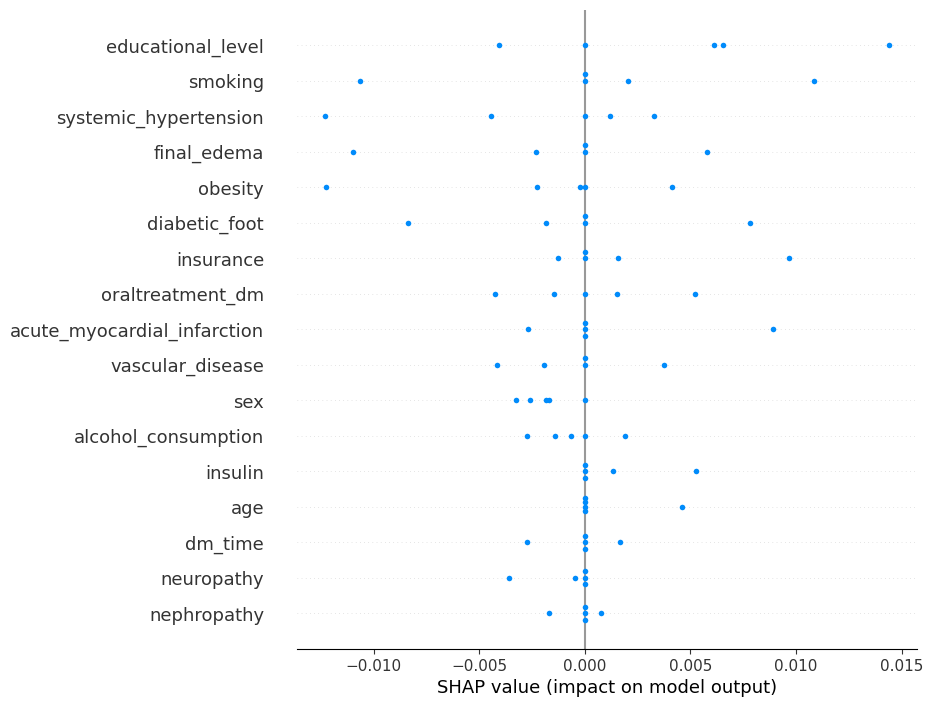

In [ ]:
shap.plots.beeswarm(shap.Explanation(shap_values[1,:,:].reshape((5, -1)), features_test_df, feature_names=feature_names), max_display=17)

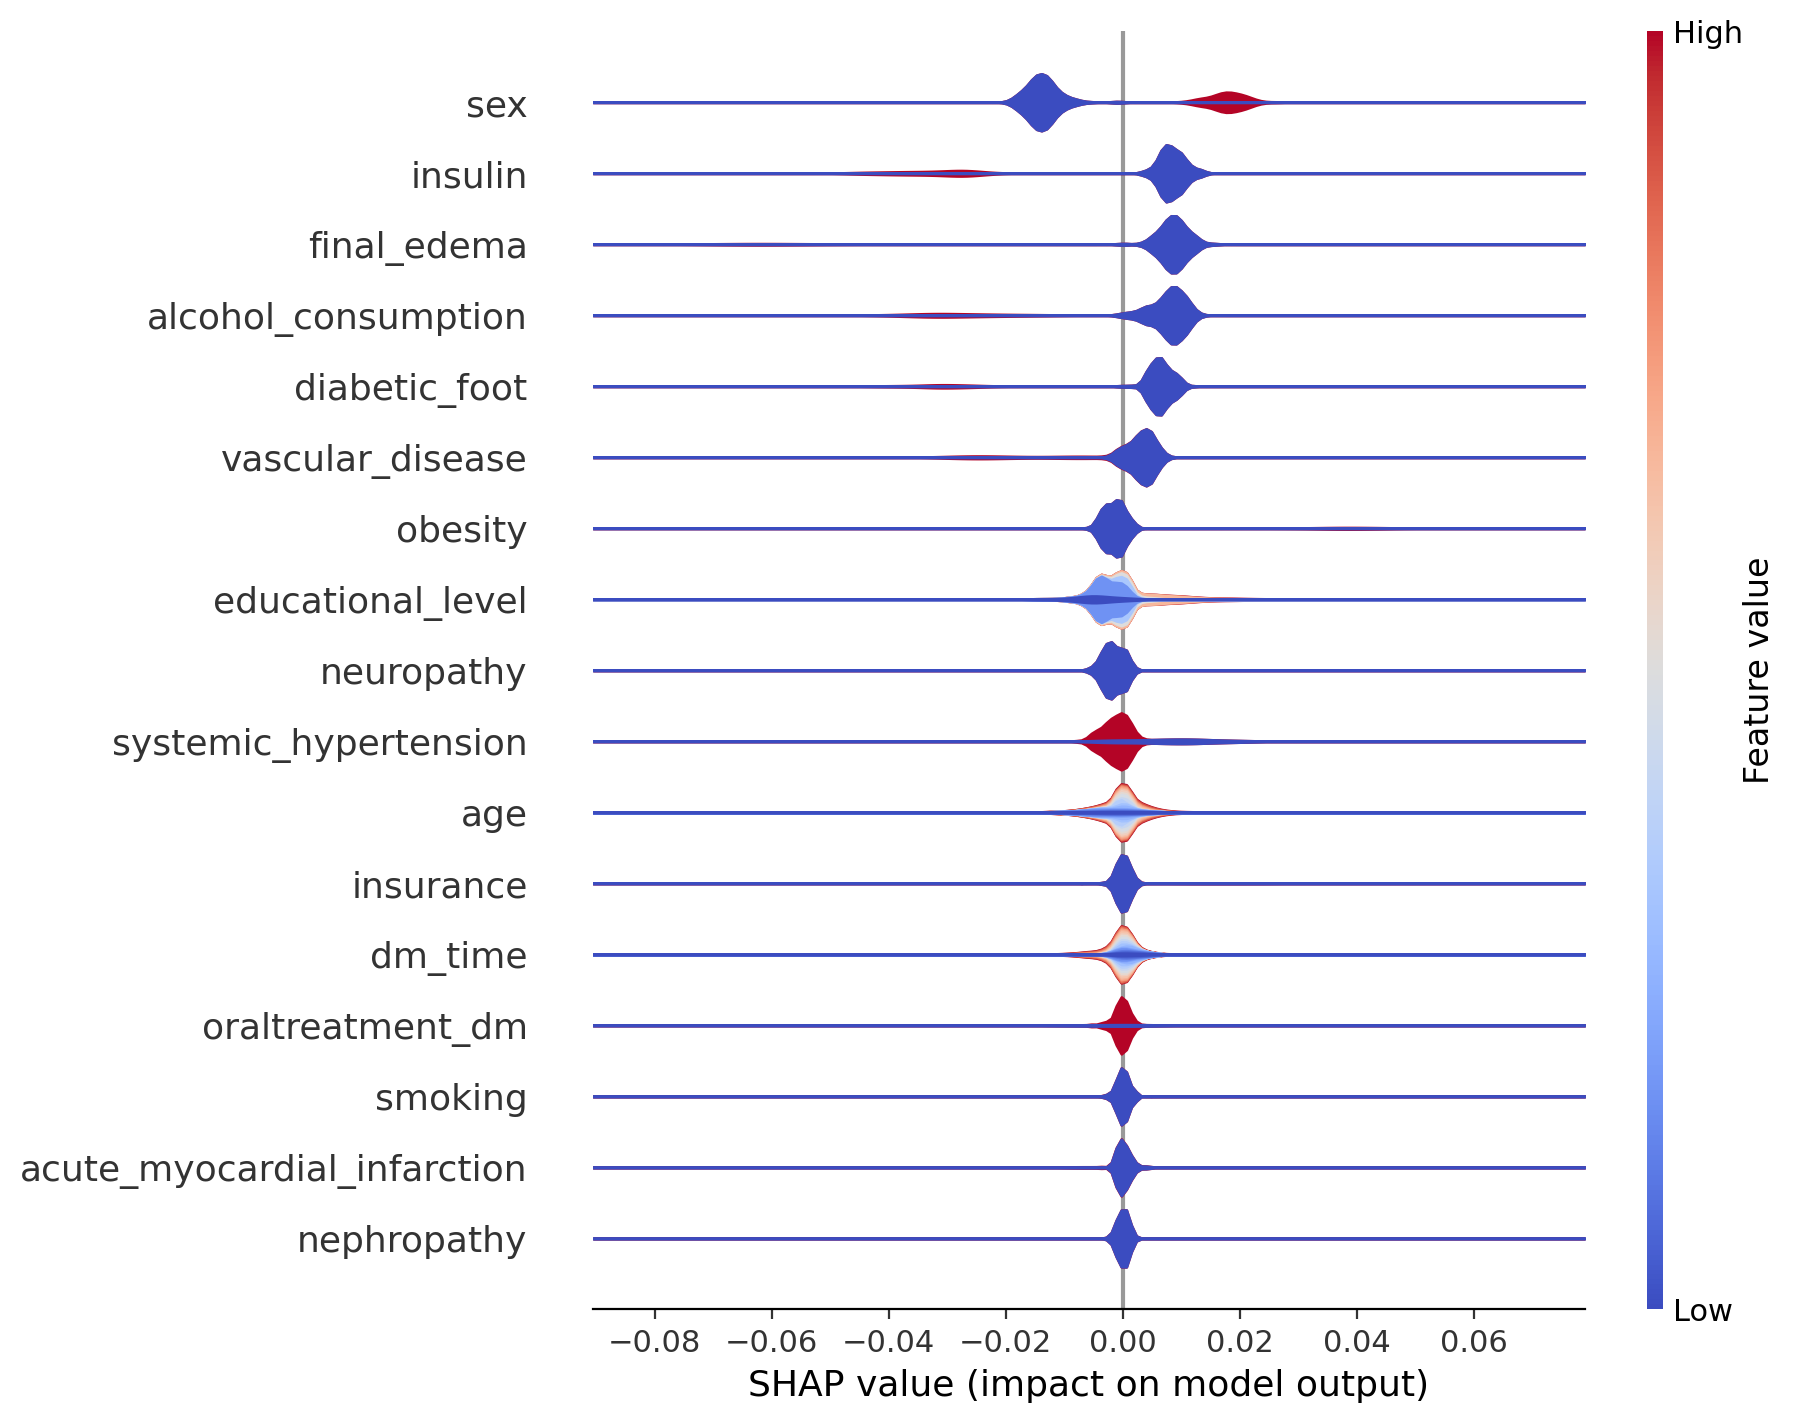

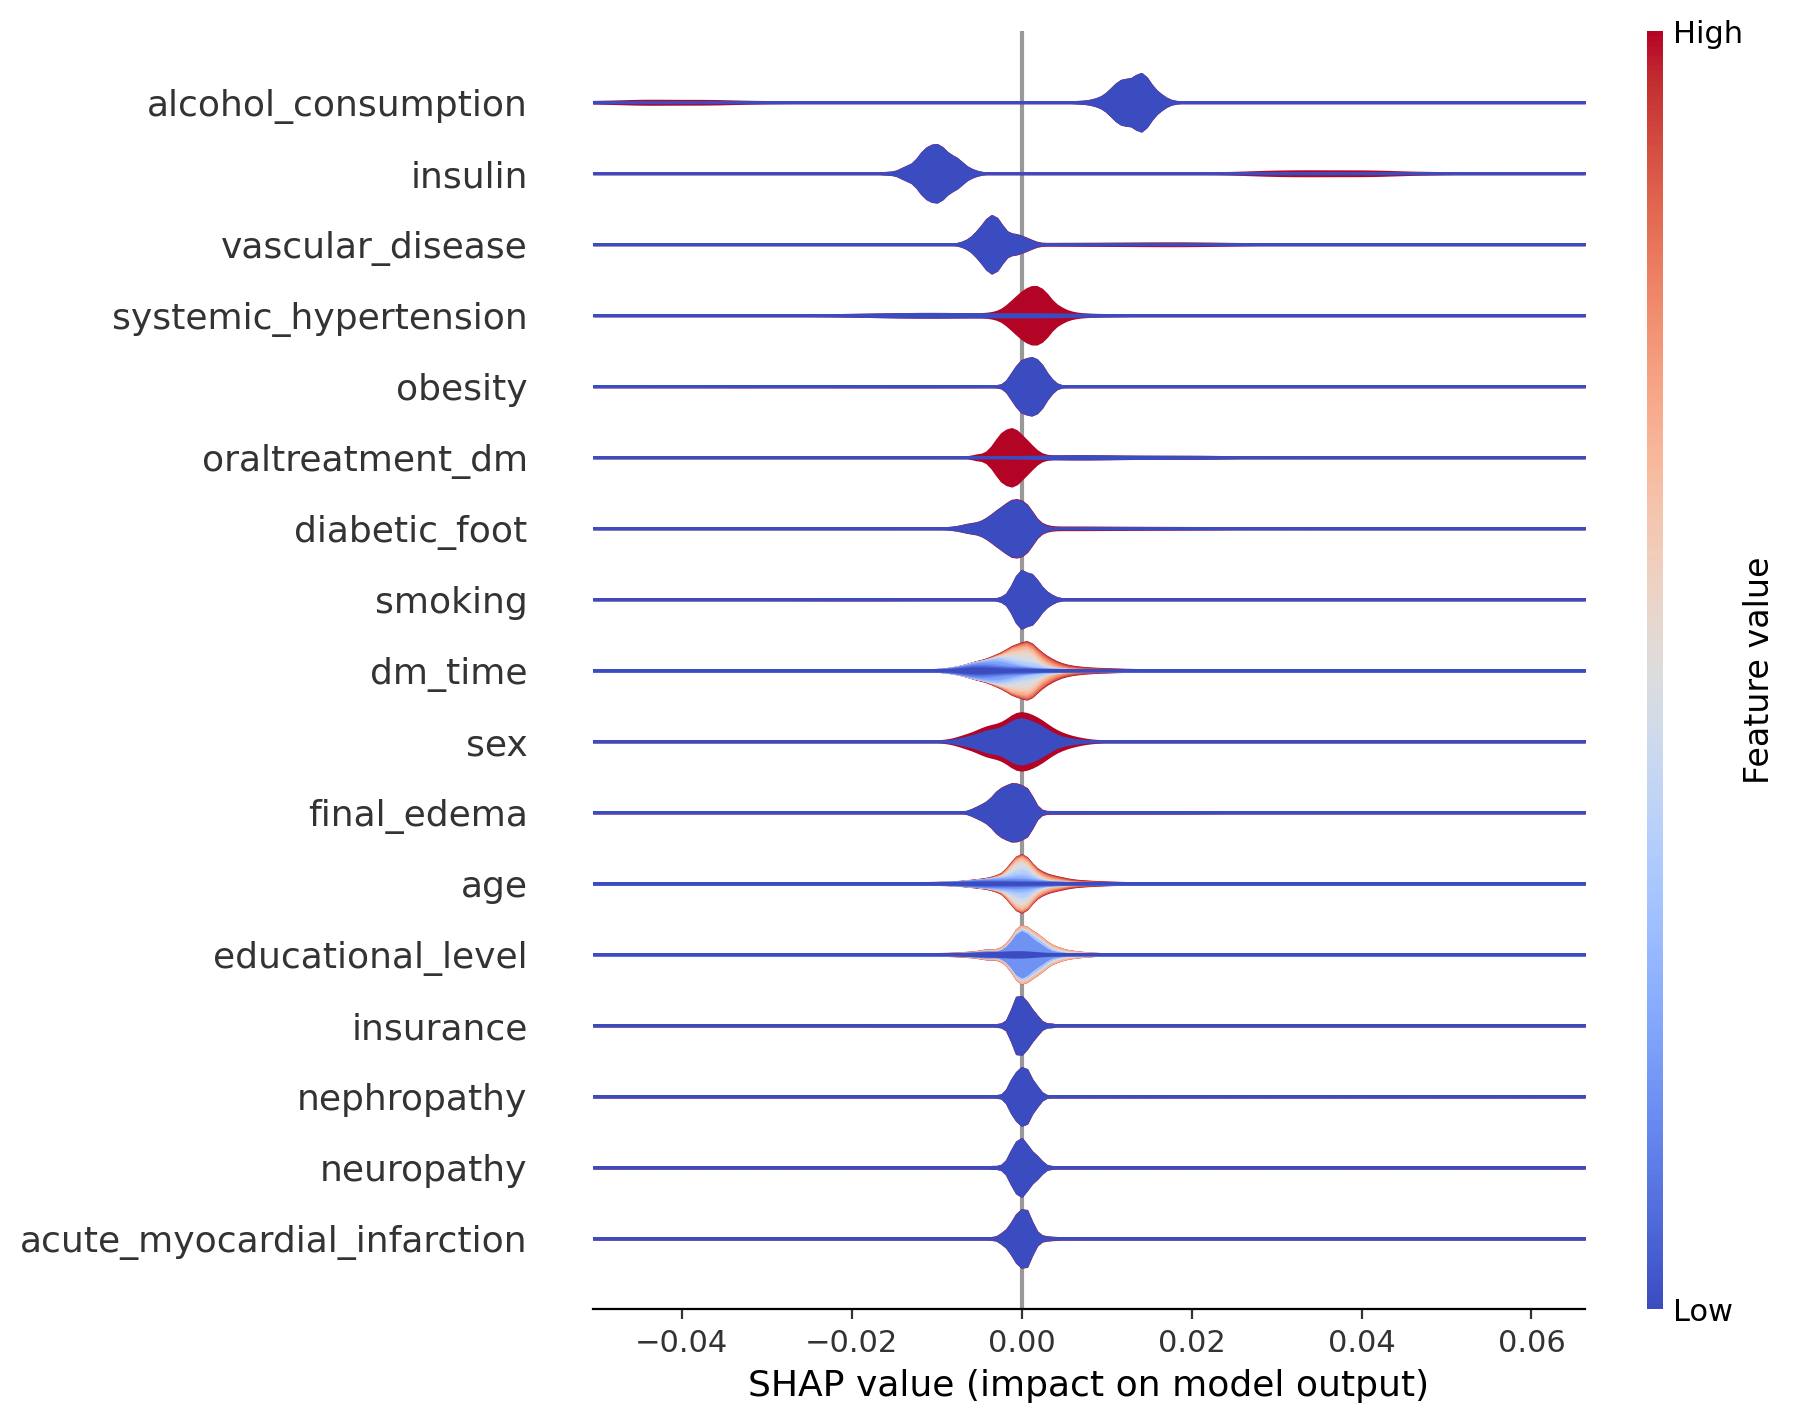

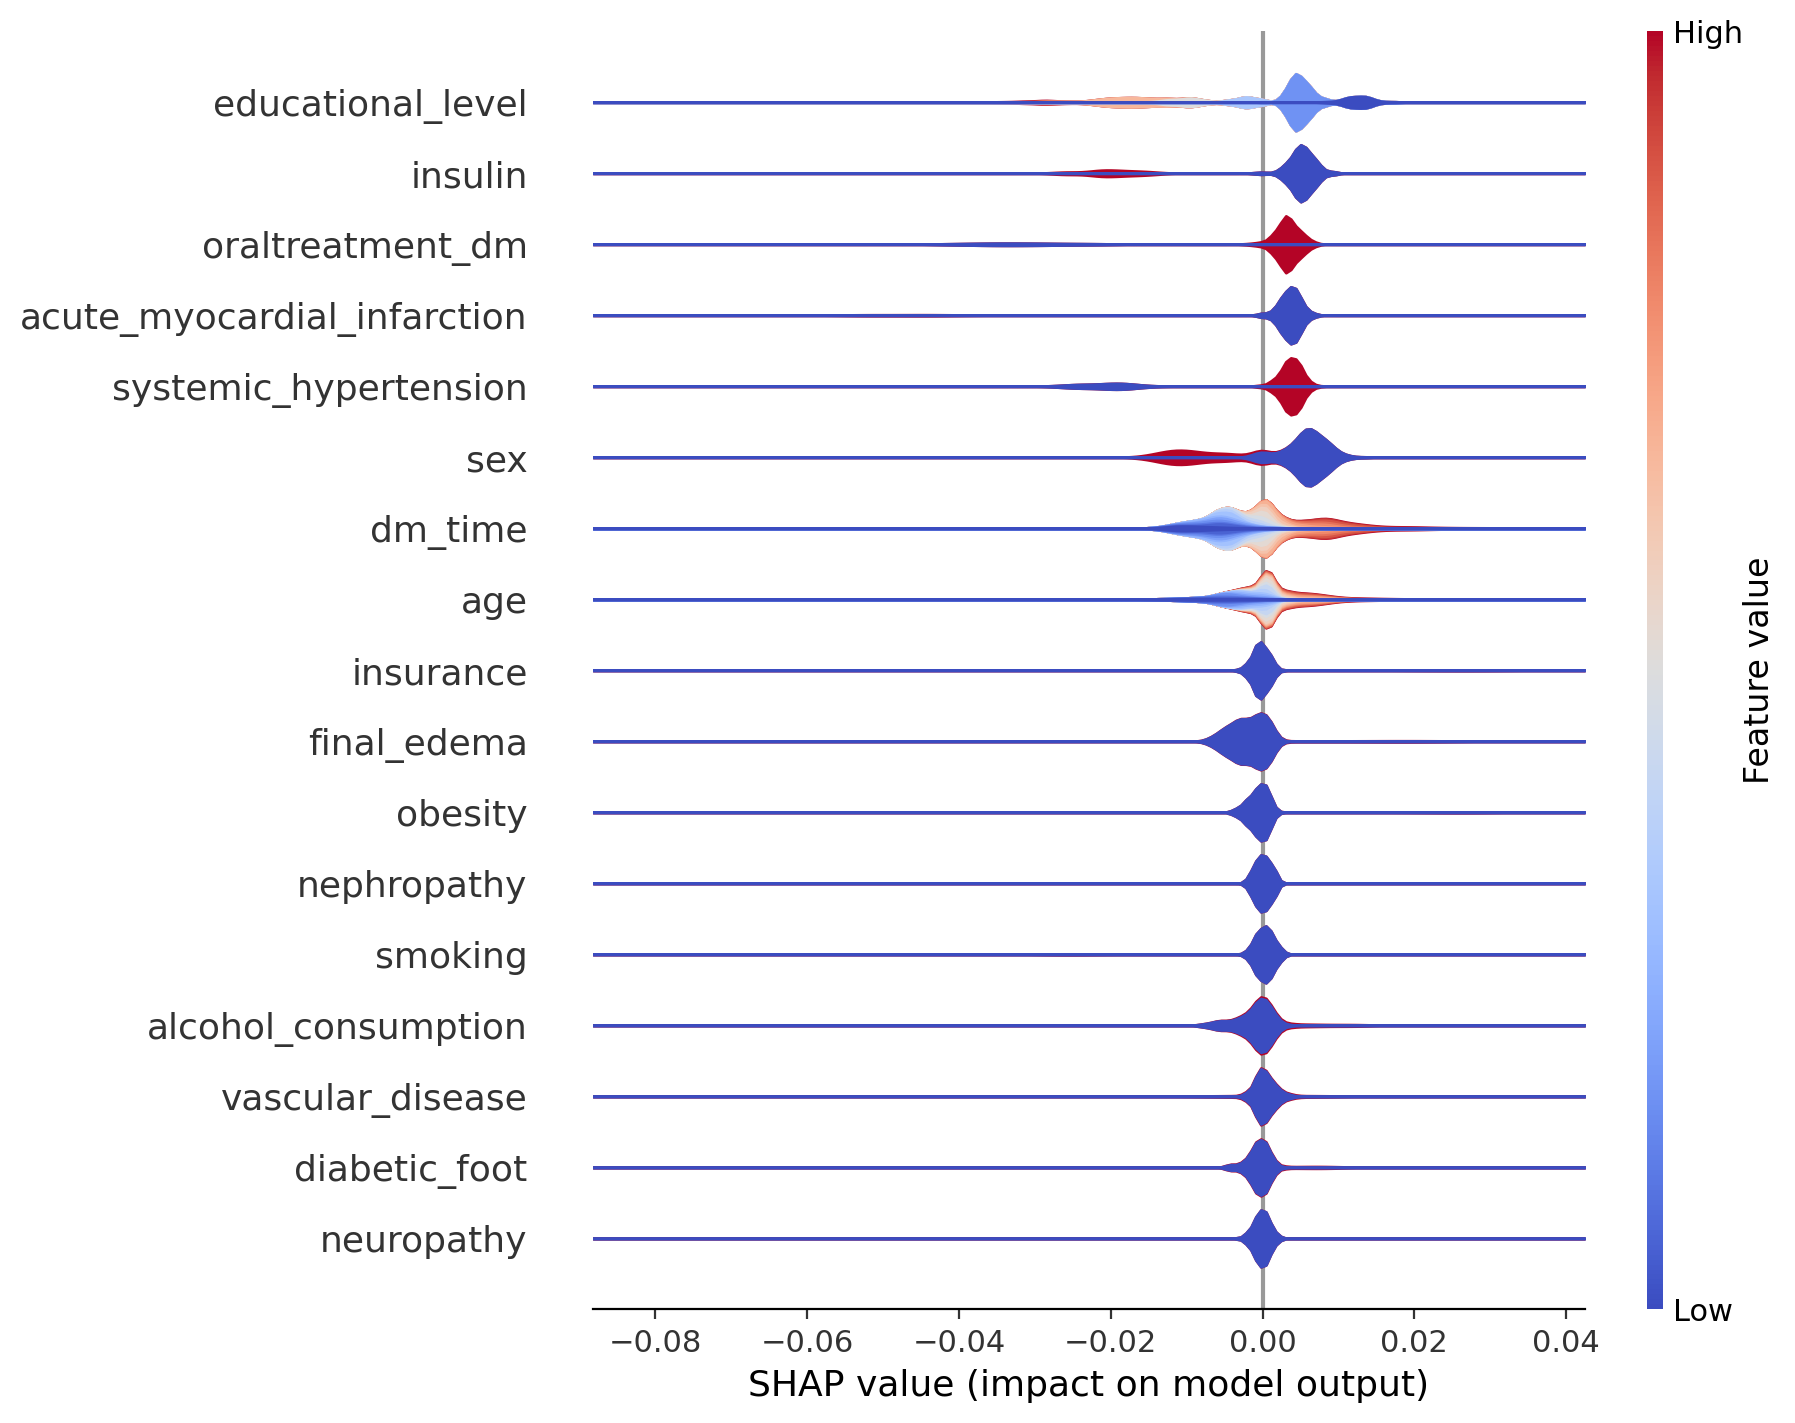

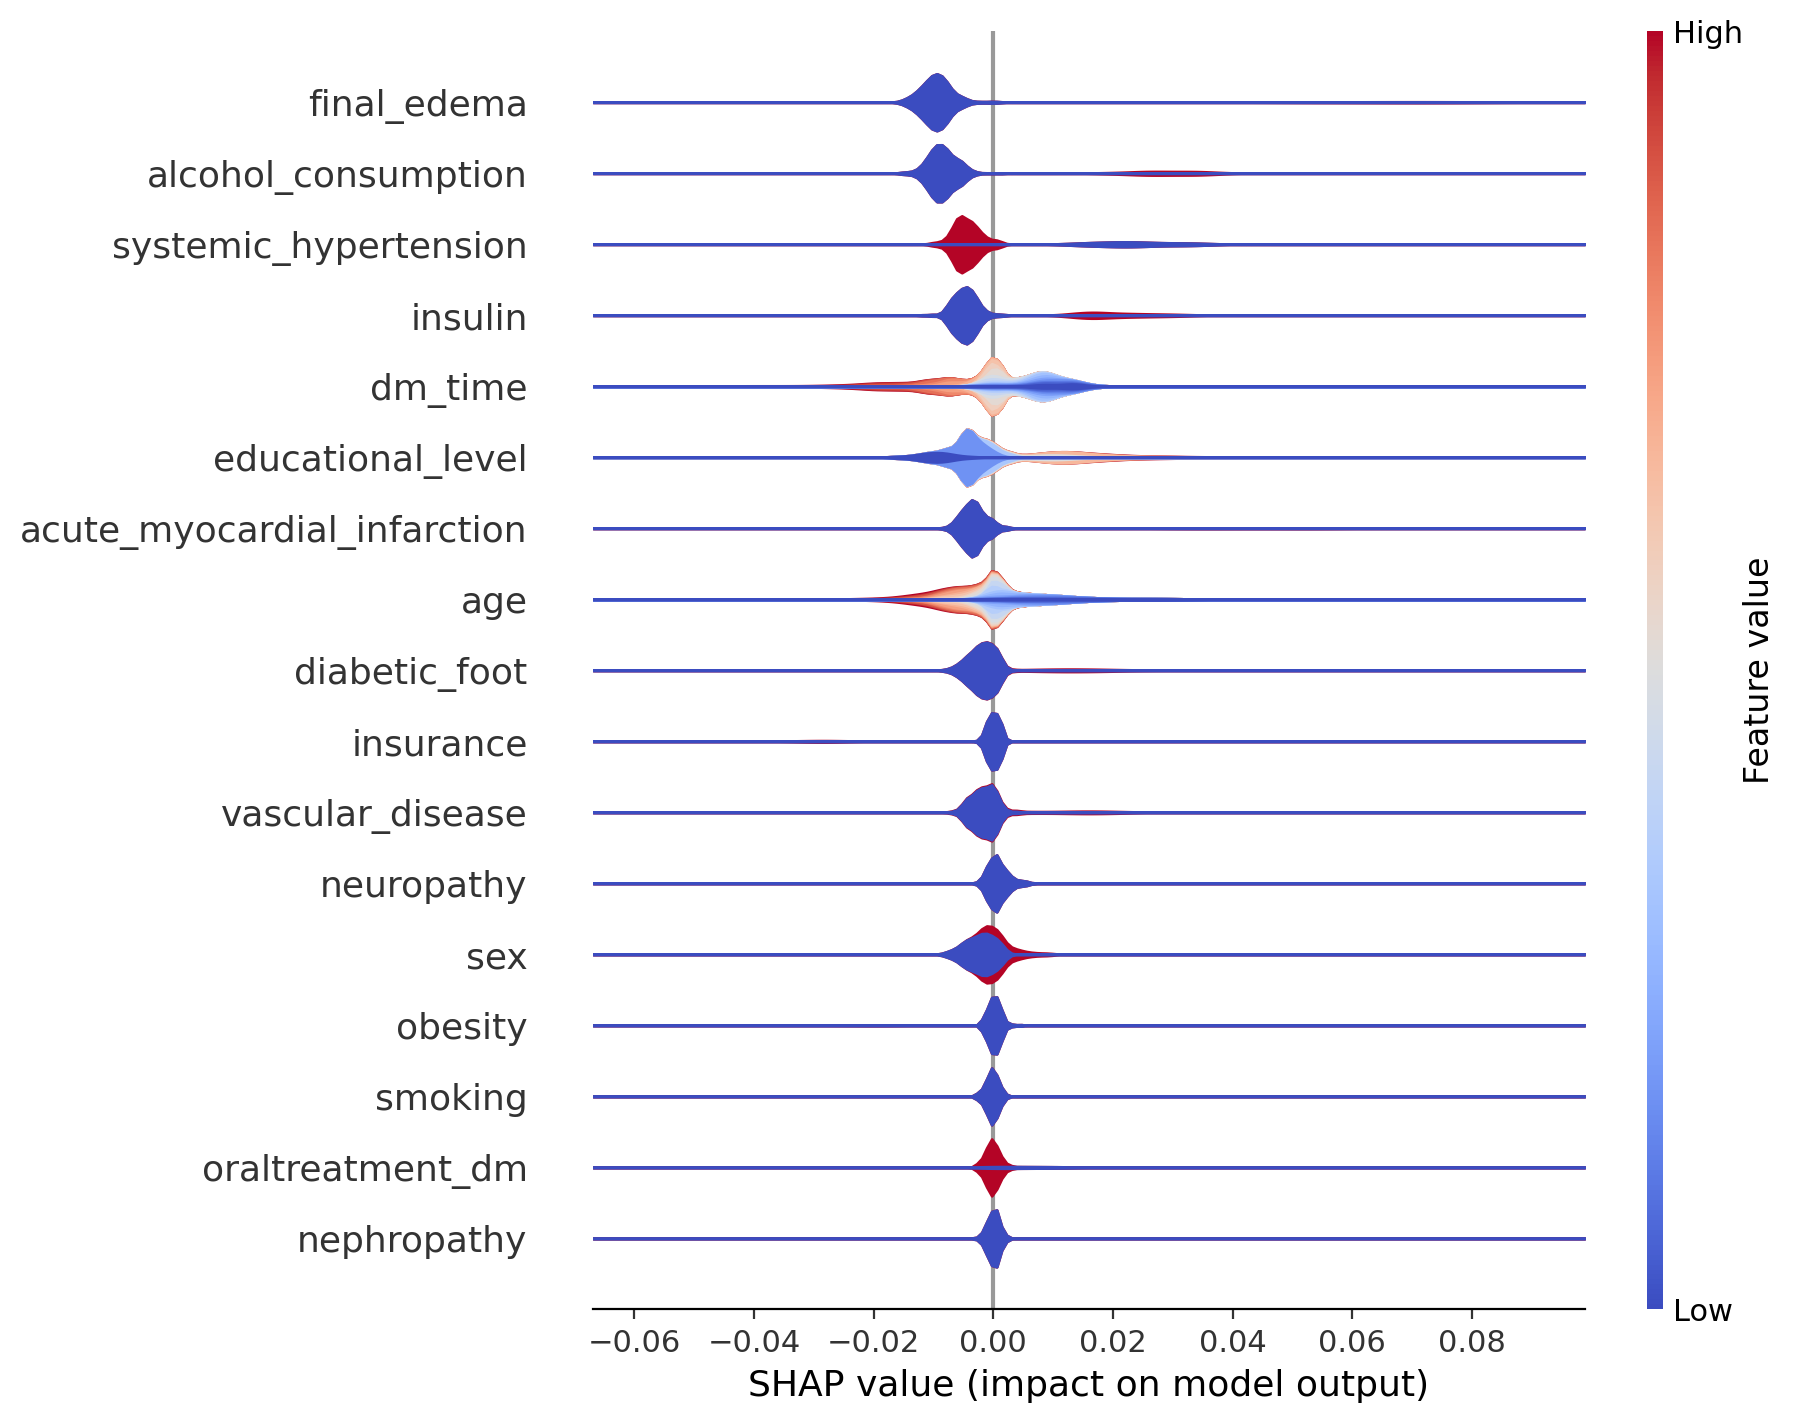

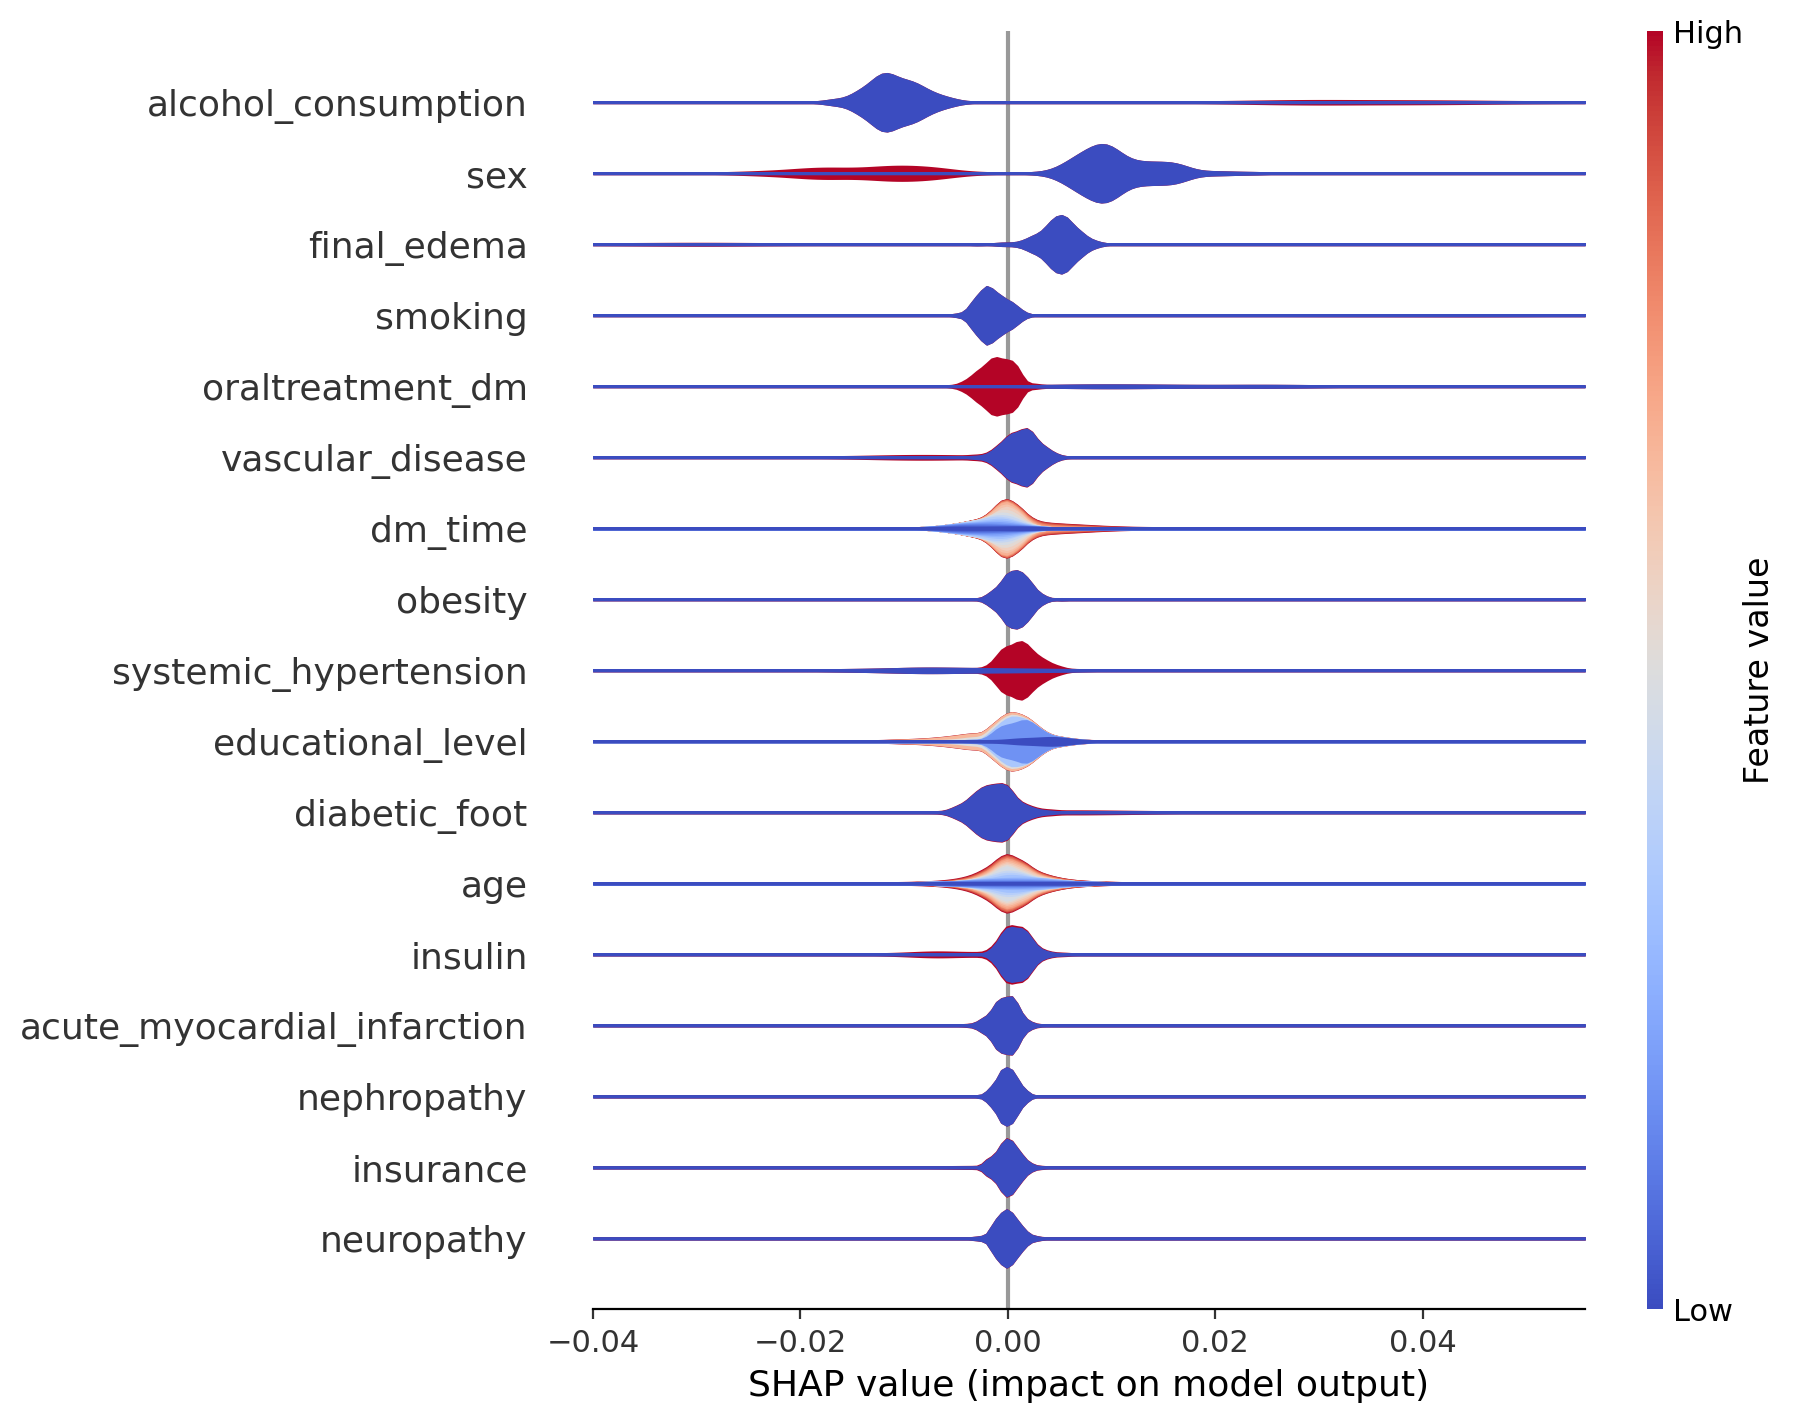

In [ ]:
# Violin plot! Each of the 17 features are represented by a distribution of SHAP scores across 246 test samples
for i in range(5):
  plt.figure(dpi=200, figsize=(5, 5))
  shap.plots.violin(shap_values[:,:,i], features=features_test_df, feature_names=feature_names, plot_type='layered_violin')
  plt.show()


In [ ]:
# unfinished below this
shap.plots.scatter(explanation[:, "Age"])

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1144: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pl.yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=13)


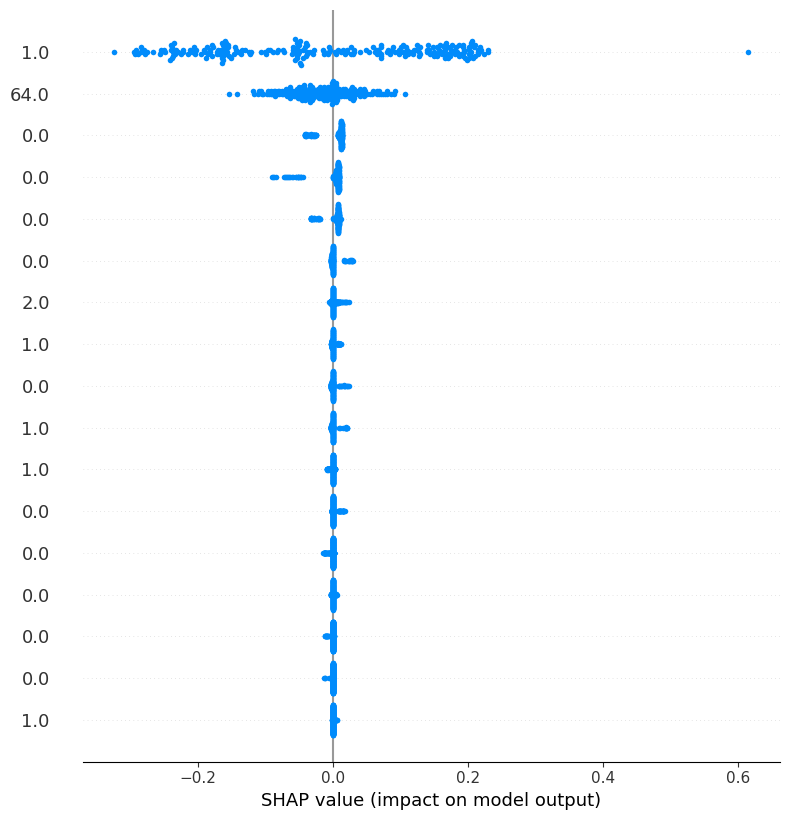

In [ ]:
shap.initjs()

# single sample "force plot" explaining what features contributed to model's prediction on this sample
shap.plots.force(base_value = explainer.expected_value[0],
                 shap_values = shap_values[:,:,0],
                 feature_names = feature_names
                 )


# multi sample "force plot"

# summary plot
shap.summary_plot(shap_values = shap_values[:,:,0], features = features_test_df.iloc[101, :])
